# COVID-19: Predicting the Spread of Coronavirus

### A Data Science Project by:
### Ronald DeLuca & Lulu Melhem
#### March 10th, 2020

In [1]:
import pandas as pd
import numpy as np 
import re
import glob
import datetime
import tabulate
import time
from math import sqrt
from IPython.display import HTML, display
from matplotlib import pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter
#import matplotlib.ticker as mticker
#import mplfinance as mpf
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNetCV
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score, mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance, mean_tweedie_deviance, max_error
from sklearn.metrics import explained_variance_score
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import logging, sys
logging.disable(sys.maxsize)

In [2]:
t1 = time.time()
# Read all CSVs from data/ folder, preprocess columns and inject Dates from filename
# Concatenate all CSVs into one dataframe, ensuring different formats align correctly.
all_files = glob.glob('./data' + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df.rename(columns={'Country/Region':'Country'}, inplace=True)
    df.rename(columns={'Country_Region':'Country'}, inplace=True)
    df.rename(columns={'Province/State':'Province_State'}, inplace=True)
    df.rename(columns={'Last Update':'Last_Update'}, inplace=True)
    df.rename(columns={'Admin2':'City'}, inplace=True)
    df.rename(columns={'Lat':'Latitude'}, inplace=True)
    df.rename(columns={'Long_':'Longitude'}, inplace=True)
    dateRe = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", filename)
    #print(dateRe.group(1))
    df['Date'] = dateRe.group(1)
    li.append(df)

covidCompiled = pd.concat(li, axis=0, ignore_index=True)
covidCompiled = covidCompiled[['Date', 'Last_Update', 'Province_State', 'Country', 'Confirmed', 'Deaths', 'Recovered', 
        'Active', 'Latitude', 'Longitude', 'FIPS', 'City', 'Combined_Key']]
values = {'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}
covidCompiled.fillna(value=values, inplace=True)
covidCompiled['Last_Update'] =pd.to_datetime(covidCompiled.Last_Update)
covidCompiled['Confirmed'] =pd.to_numeric(covidCompiled.Confirmed)
covidCompiled['Deaths'] =pd.to_numeric(covidCompiled.Deaths)
covidCompiled['Recovered'] =pd.to_numeric(covidCompiled.Recovered)
covidCompiled['Active'] =pd.to_numeric(covidCompiled.Active)
covidCompiled = covidCompiled.sort_values(['Last_Update'], ascending=(True))
covidCompiled = covidCompiled.reset_index(drop=True)
#covidCompiled['Date'] = covidCompiled['Last_Update'].values
covidCompiled['Date'] = pd.to_datetime(covidCompiled['Date']).dt.date
#cols = covidCompiled.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#covidCompiled = covidCompiled[cols]
covidCompiled.to_csv('covidCompiled.csv')
covidCompiled
t2 = time.time()
print('Runtime:', t2-t1)

Runtime: 1.450768232345581


In [3]:
t3=time.time()
# Use compiled df to fill in missing values in older CSVs through searching
#count = 0;
covidFilled = covidCompiled
for row in covidFilled.itertuples():
    if row[13] != row[13]:
        if row[3] != row[3]:
            covidFilled.at[row[0], 'Combined_Key'] = row[4]
        else:
            covidFilled.at[row[0], 'Combined_Key'] = row[3] + ', ' + row[4]
    if row[9] != row[9]:
        found = covidFilled.loc[(covidFilled['Province_State'] == row[3]) & 
                (covidFilled['Latitude'] == covidFilled['Latitude'])]
        if 0 < len(found.values):
            covidFilled.at[row[0], 'Latitude'] = found.values[0][8]
        else:
            newfound = covidFilled.loc[(covidFilled['Country'] == row[4]) & 
                (covidFilled['Latitude'] == covidFilled['Latitude'])]
            if 0 < len(newfound.values):
                covidFilled.at[row[0], 'Latitude'] = newfound.values[0][8]
    if row[10] != row[10]:
        found = covidFilled.loc[(covidFilled['Province_State'] == row[3]) & 
                (covidFilled['Longitude'] == covidFilled['Longitude'])]
        if 0 < len(found.values):
            covidFilled.at[row[0], 'Longitude'] = found.values[0][9]
        else:
            newfound = covidFilled.loc[(covidFilled['Country'] == row[4]) & 
                (covidFilled['Longitude'] == covidFilled['Longitude'])]
            if 0 < len(newfound.values):
                covidFilled.at[row[0], 'Longitude'] = newfound.values[0][9]

for row in covidFilled.itertuples():
    if row[12] != row[12]:
        cityFound = covidFilled.loc[(covidFilled['Latitude'] == row[9]) & 
                (covidFilled['Longitude'] == row[10]) & 
                (covidFilled['City'] == covidFilled['City'])]
        if 0 < len(cityFound.values):
            covidFilled.at[row[0], 'City'] = cityFound.values[0][11]
    if row[11] != row[11]:
        fipsfound = covidFilled.loc[(covidFilled['Latitude'] == row[9]) & 
                (covidFilled['Longitude'] == row[10]) & 
                (covidFilled['FIPS'] == covidFilled['FIPS'])]
        if 0 < len(fipsfound.values):
                covidFilled.at[row[0], 'FIPS'] = fipsfound.values[0][10]
        else:
            newfipsfound = covidFilled.loc[(covidFilled['City'] == row[12]) & 
                (covidFilled['FIPS'] == covidFilled['FIPS'])]
            if 0 < len(newfipsfound.values):
                covidFilled.at[row[0], 'FIPS'] = newfipsfound.values[0][10]

    #count += 1
covidFilled.to_csv('covidFilled.csv')
covidFilled
t4 = time.time()
print('Runtime:', t4-t3)

Runtime: 181.797949552536


In [4]:
t5=time.time()
# Johns Hopkins CSVs pulled here to verify numbers against.
#confirmedUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmedUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmedUrlUSTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
#deathsUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deathsUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deathsUrlUSTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
#recoveredUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recoveredUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
#covidCompiled = './covid_19_data.csv'
openLineCovid = './COVID19_open_line_list.csv'
df_confirmed = pd.read_csv(confirmedUrlTs)
df_confirmedUS = pd.read_csv(confirmedUrlUSTs)
df_deaths = pd.read_csv(deathsUrlTs)
df_deathsUS = pd.read_csv(deathsUrlUSTs)
df_recovered = pd.read_csv(recoveredUrlTs)
df_kOLine = pd.read_csv(openLineCovid)
df_kOLine = df_kOLine.dropna(how='all')
df_kOLine = df_kOLine.dropna(how='all', axis=1)
#df_compiled = pd.read_csv(covidCompiled, parse_dates=['Last Update'])

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
#df_compiled.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)
#df_confirmed.head()
t6 = time.time()
print('Runtime:', t6-t5)

Runtime: 1.2376530170440674


In [5]:
## Kaggle COVID19 Open Line List CSV
df_kOLine

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,NaN,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui,China,340181,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,NaN,NaN,NaN,NaN,Baohe District,Hefei City,Anhui,China,340111,NaN
2,3.0,49,male,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
3,4.0,47,female,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
4,5.0,50,female,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,NaN,NaN,NaN,NaN,Feidong County,Hefei City,Anhui,China,340122,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,13475.0,60-69,male,Nagoya City,Aichi Prefecture,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13170,13476.0,40-49,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13171,13477.0,0-10,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13172,13478.0,NaN,female,Amsterdam,NaN,Netherlands,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
t7=time.time()
count = 0
upper = 1
new_df = pd.DataFrame()
for row in df_confirmed.itertuples():
    count += 1
    upper += 1
    if upper < len(df_confirmed.index):
        confir = df_confirmed[count:upper].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[count:upper].T
        death = deat[4:]
        #recov = df_recovered[count:upper].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
    elif upper == len(df_confirmed.index):
        confir = df_confirmed[-1:].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[-1:].T
        death = deat[4:]
        #recov = df_recovered[-1:].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
    else:
        confir = df_confirmed[:1].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[:1].T
        death = deat[4:]
        #recov = df_recovered[:1].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
        

print (count)
new_df.sort_index()
new_df['Date'] = new_df.index
cols = new_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
new_df = new_df[cols]
new_df['Date'] =pd.to_datetime(new_df.Date)
new_df['Confirmed'] =pd.to_numeric(new_df.Confirmed)
new_df['Deaths'] =pd.to_numeric(new_df.Deaths)
#new_df['Recovered'] =pd.to_numeric(new_df.Recovered)
new_df = new_df.sort_values(['Date', 'Country'], ascending=(True, True))
new_df = new_df.reset_index(drop=True)
covidFull = new_df
#covidFull.dtypes
covidFull.to_csv('basicCovid.csv')
#covidFull
t8 = time.time()
print('Runtime:', t8-t7)

258
Runtime: 2.6422016620635986


In [7]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [8]:
t9=time.time()
datesGroup = covidFilled.groupby('Date').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()
datesGroup.to_csv('datesGroup.csv')
days_range = np.array([i for i in range(len(datesGroup))]).reshape(-1, 1)
future_range = np.array([i for i in range(len(datesGroup)+10)]).reshape(-1, 1)
adjusted_dates = future_range[:-10]
start_date = datetime.datetime.strptime('2020-01-22', '%Y-%m-%d')
start_short = datetime.datetime.strptime('01-22', '%m-%d')
future_range_dates = []
future_range_dates_short = []
for i in range(len(future_range)):
    future_range_dates.append((start_date + datetime.timedelta(days=i)).strftime('%Y-%m-%d'))
    future_range_dates_short.append((start_short + datetime.timedelta(days=i)).strftime('%m-%d'))
world_confirmed = datesGroup['Confirmed'].to_numpy()
t10 = time.time()
print('Runtime:', t10-t9)

Runtime: 0.022330045700073242


In [9]:
X_train_world_confirmed, X_test_world_confirmed, y_train_world_confirmed, y_test_world_confirmed = \
train_test_split(days_range, world_confirmed, test_size=0.15, shuffle=False)

## Linear Regression

In [10]:
t11=time.time()
## Worldwide Linear Regression
linear_reg_model = LinearRegression(normalize=True, fit_intercept=False)
linear_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
test_linear_world_conf_pred = linear_reg_model.predict(X_test_world_confirmed)
linear_world_conf_pred = linear_reg_model.predict(future_range)

mAE_linear_world_conf = mean_absolute_error(y_test_world_confirmed, test_linear_world_conf_pred)
mSE_linear_world_conf = mean_squared_error(y_test_world_confirmed, test_linear_world_conf_pred)
mSLE_linear_world_conf = mean_squared_log_error(y_test_world_confirmed, test_linear_world_conf_pred)
rMSE_linear_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_linear_world_conf_pred))
mAbE_linear_world_conf = median_absolute_error(y_test_world_confirmed, test_linear_world_conf_pred)
mAPE_linear_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_linear_world_conf_pred)
r2_linear_world_conf = r2_score(y_test_world_confirmed, test_linear_world_conf_pred)
mPD_linear_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mGD_linear_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mTD_linear_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mE_linear_world_conf = max_error(y_test_world_confirmed, test_linear_world_conf_pred)
mEVS_linear_world_conf = explained_variance_score(y_test_world_confirmed, test_linear_world_conf_pred)

print('Linear Regression on Worldwide Confirmed Cases: ')

table = [[mAE_linear_world_conf,mSE_linear_world_conf,mSLE_linear_world_conf,
          rMSE_linear_world_conf,mAbE_linear_world_conf,mAPE_linear_world_conf,
          r2_linear_world_conf,mPD_linear_world_conf,mGD_linear_world_conf,
          mTD_linear_world_conf,mE_linear_world_conf,mEVS_linear_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t12 = time.time()
print('Runtime:', t12-t11)

Linear Regression on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
516911,3.08743e+11,1.44761,555646,503319,68.0943,-5.73923,799747,2.33937,3.08743e+11,862940,0.0931443


Runtime: 0.010029077529907227


In [11]:
t13=time.time()
linear_world_conf_pred = linear_world_conf_pred.reshape(1,-1)[0]
print('Linear Regression Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(linear_world_conf_pred[-10:])))
t14 = time.time()
print('Runtime:', t14-t13)

Linear Regression Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.00022935867309570312


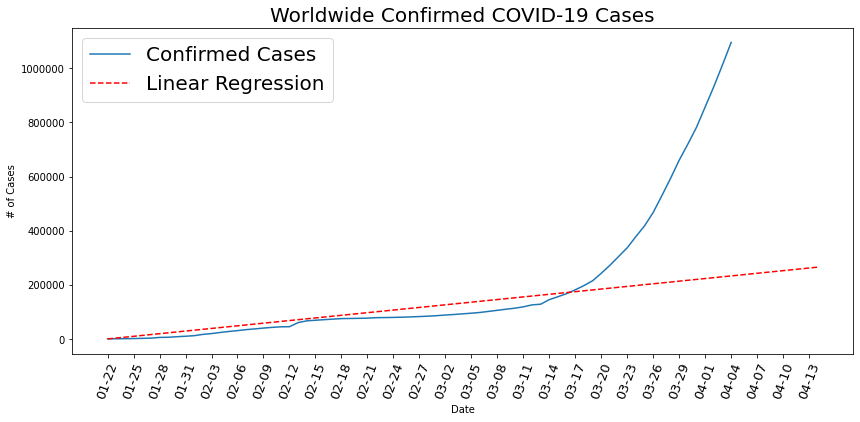

Runtime: 0.25106120109558105


In [12]:
t15=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, linear_world_conf_pred, linestyle='dashed', color='red')
plt.title('Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Linear Regression'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t16 = time.time()
print('Runtime:', t16-t15)

## Polynomial Regression

In [13]:
t17=time.time()
## Worldwide Polynomial Regression
poly_features = PolynomialFeatures(degree=5)
poly_X_train_world_confirmed = poly_features.fit_transform(X_train_world_confirmed)
poly_X_test_world_confirmed = poly_features.fit_transform(X_test_world_confirmed)
poly_future_world_forecast = poly_features.fit_transform(future_range)

poly_reg_model = LinearRegression(normalize=True, fit_intercept=False)
poly_reg_model.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
test_poly_world_conf_pred = poly_reg_model.predict(poly_X_test_world_confirmed)
poly_world_conf_pred = poly_reg_model.predict(poly_future_world_forecast)

mAE_poly_world_conf = mean_absolute_error(y_test_world_confirmed, test_poly_world_conf_pred)
mSE_poly_world_conf = mean_squared_error(y_test_world_confirmed, test_poly_world_conf_pred)
mSLE_poly_world_conf = mean_squared_log_error(y_test_world_confirmed, test_poly_world_conf_pred)
rMSE_poly_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_poly_world_conf_pred))
mAbE_poly_world_conf = median_absolute_error(y_test_world_confirmed, test_poly_world_conf_pred)
mAPE_poly_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_poly_world_conf_pred)
r2_poly_world_conf = r2_score(y_test_world_confirmed, test_poly_world_conf_pred)
mPD_poly_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mGD_poly_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mTD_poly_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mE_poly_world_conf = max_error(y_test_world_confirmed, test_poly_world_conf_pred)
mEVS_poly_world_conf = explained_variance_score(y_test_world_confirmed, test_poly_world_conf_pred)

print('Polynomial Regression on Worldwide Confirmed Cases: ')
table = [[mAE_poly_world_conf,mSE_poly_world_conf,mSLE_poly_world_conf,
          rMSE_poly_world_conf,mAbE_poly_world_conf,mAPE_poly_world_conf,
          r2_poly_world_conf,mPD_poly_world_conf,mGD_poly_world_conf,
          mTD_poly_world_conf,mE_poly_world_conf,mEVS_poly_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t18=time.time()
print('Runtime:', t18-t17)

Polynomial Regression on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
22124.6,9.83979e+08,0.0010241,31368.4,13936.6,2.58176,0.978522,972.076,0.00101234,9.83979e+08,77465,0.980811


Runtime: 0.010569572448730469


In [14]:
t19=time.time()
poly_world_conf_pred = poly_world_conf_pred.reshape(1,-1)[0]
print('Polynomial Regression Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(poly_world_conf_pred[-10:])))
t20 = time.time()
print('Runtime:', t20-t19)

Polynomial Regression Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.00023865699768066406


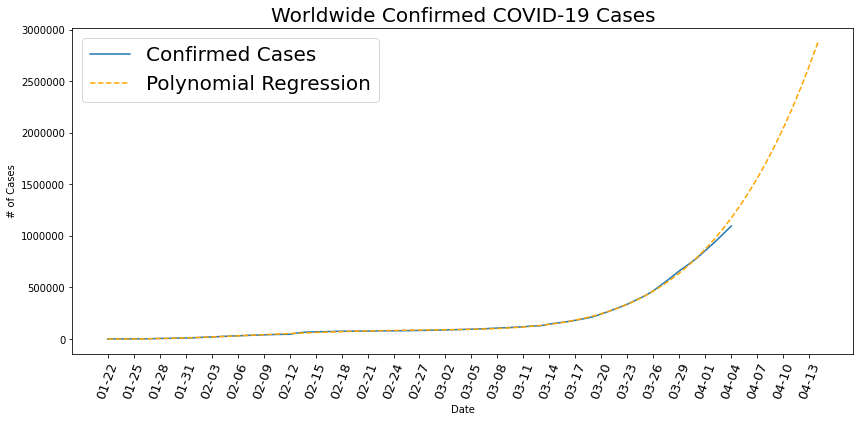

Runtime: 0.34311866760253906


In [15]:
t21=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, poly_world_conf_pred, linestyle='dashed', color='orange')
plt.title('Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Polynomial Regression'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t22 = time.time()
print('Runtime:', t22-t21)

## SVM

In [16]:
t23=time.time()
# Worldwide SVM Predictions
svm_reg_model = svm.SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=6, C=0.1)
svm_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
test_svm_world_conf_pred = svm_reg_model.predict(X_test_world_confirmed)
svm_world_conf_pred = svm_reg_model.predict(future_range)

mAE_svm_world_conf = mean_absolute_error(y_test_world_confirmed, test_svm_world_conf_pred)
mSE_svm_world_conf = mean_squared_error(y_test_world_confirmed, test_svm_world_conf_pred)
mSLE_svm_world_conf = mean_squared_log_error(y_test_world_confirmed, test_svm_world_conf_pred)
rMSE_svm_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_svm_world_conf_pred))
mAbE_svm_world_conf = median_absolute_error(y_test_world_confirmed, test_svm_world_conf_pred)
mAPE_svm_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_svm_world_conf_pred)
r2_svm_world_conf = r2_score(y_test_world_confirmed, test_svm_world_conf_pred)
mPD_svm_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_svm_world_conf_pred)
mGD_svm_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_svm_world_conf_pred)
mTD_svm_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_svm_world_conf_pred)
mE_svm_world_conf = max_error(y_test_world_confirmed, test_svm_world_conf_pred)
mEVS_svm_world_conf = explained_variance_score(y_test_world_confirmed, test_svm_world_conf_pred)

print('SVM on Worldwide Confirmed Cases: ')
table = [[mAE_svm_world_conf,mSE_svm_world_conf,mSLE_svm_world_conf,
          rMSE_svm_world_conf,mAbE_svm_world_conf,mAPE_svm_world_conf,
          r2_svm_world_conf,mPD_svm_world_conf,mGD_svm_world_conf,
          mTD_svm_world_conf,mE_svm_world_conf,mEVS_svm_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t24 = time.time()
print('Runtime:', t24-t23)

SVM on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
130381,2.04481e+10,0.0362792,142997,134922,16.7834,0.553658,27508.6,0.0388727,2.04481e+10,218810,0.924719


Runtime: 0.08660387992858887


In [17]:
t25=time.time()
svm_world_conf_pred = svm_world_conf_pred.reshape(1,-1)[0]
print('SVM Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(svm_world_conf_pred[-10:])))
t26 = time.time()
print('Runtime:', t26-t25)

SVM Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.000247955322265625


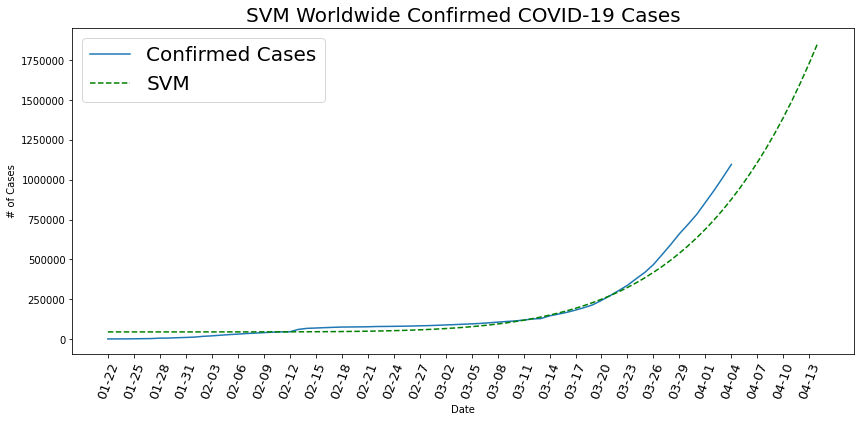

Runtime: 0.2627878189086914


In [18]:
t27=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, svm_world_conf_pred, linestyle='dashed', color='green')
plt.title('SVM Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'SVM'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t28 = time.time()
print('Runtime:', t28-t27)

## XGBoost

In [19]:
xgb_model = XGBRegressor(booster='gblinear', lamba=20, alpha=0.2)
xgb_model.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
#xgb_model.fit(X_train_world_confirmed, y_train_world_confirmed,
#        eval_set=[(X_train_world_confirmed, y_train_world_confirmed), 
#                  (X_test_world_confirmed, y_test_world_confirmed)],
#        early_stopping_rounds=50,
#       verbose=False)
test_xgb_world_conf_pred = xgb_model.predict(poly_X_test_world_confirmed)
xgb_world_conf_pred = xgb_model.predict(poly_future_world_forecast)

mAE_xgb_world_conf = mean_absolute_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mSE_xgb_world_conf = mean_squared_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mSLE_xgb_world_conf = mean_squared_log_error(y_test_world_confirmed, test_xgb_world_conf_pred)
rMSE_xgb_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_xgb_world_conf_pred))
mAbE_xgb_world_conf = median_absolute_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mAPE_xgb_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_xgb_world_conf_pred)
r2_xgb_world_conf = r2_score(y_test_world_confirmed, test_xgb_world_conf_pred)
mPD_xgb_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_xgb_world_conf_pred)
mGD_xgb_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_xgb_world_conf_pred)
mTD_xgb_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_xgb_world_conf_pred)
mE_xgb_world_conf = max_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mEVS_xgb_world_conf = explained_variance_score(y_test_world_confirmed, test_xgb_world_conf_pred)

print('XGBoost on Worldwide Confirmed Cases: ')
table = [[mAE_xgb_world_conf,mSE_xgb_world_conf,mSLE_xgb_world_conf,
          rMSE_xgb_world_conf,mAbE_xgb_world_conf,mAPE_xgb_world_conf,
          r2_xgb_world_conf,mPD_xgb_world_conf,mGD_xgb_world_conf,
          mTD_xgb_world_conf,mE_xgb_world_conf,mEVS_xgb_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

XGBoost on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
276973,9.36655e+10,0.213546,306048,270348,35.5323,-1.04453,150768,0.254492,9.36655e+10,496118,0.62998


In [20]:
#xgb_world_conf_pred
xgb_world_conf_pred = xgb_world_conf_pred.reshape(1,-1)[0]
print('XGBoost Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(xgb_world_conf_pred[-10:])))

XGBoost Worldwide Confirmed Cases Future Predictions: 


{('2020-04-04', 634651.0),
 ('2020-04-05', 671270.0),
 ('2020-04-06', 709725.0),
 ('2020-04-07', 750087.0),
 ('2020-04-08', 792428.0),
 ('2020-04-09', 836821.0),
 ('2020-04-10', 883344.0),
 ('2020-04-11', 932074.0),
 ('2020-04-12', 983091.0),
 ('2020-04-13', 1036476.0)}

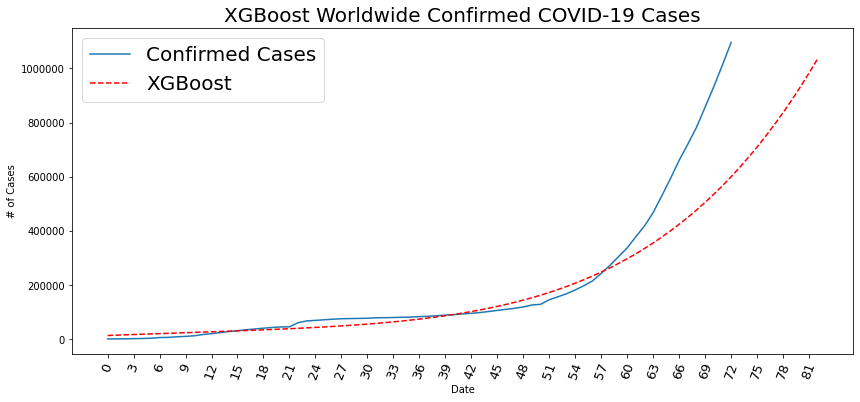

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range, xgb_world_conf_pred, linestyle='dashed', color='red')
plt.title('XGBoost Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'XGBoost'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

## ARIMA

In [22]:
arma_reg_model = ARIMA(world_confirmed, order=(1, 2, 0))
#neighbors_classifier.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
#arma_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
arma_model_fit = arma_reg_model.fit(disp=False)
test_arma_world_conf_pred = arma_reg_model.predict(X_test_world_confirmed)
print(arma_model_fit.summary())
residuals = pd.DataFrame(arma_model_fit.resid)
#residuals.plot()
arma_model_fit
#pyplot.show()
#yhat = arma_model_fit.predict(X_test_world_confirmed, future_range, typ='levels')
#print(yhat)
#test_arma_world_conf_pred = arma_reg_model.predict(X_test_world_confirmed)
#arma_world_conf_pred = arma_reg_model.predict(future_range)

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   71
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -692.443
Method:                       css-mle   S.D. of innovations           4161.270
Date:                Fri, 03 Apr 2020   AIC                           1390.886
Time:                        20:55:20   BIC                           1397.674
Sample:                             2   HQIC                          1393.585
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1164.4836    423.220      2.751      0.006     334.988    1993.979
ar.L1.D2.y    -0.1693      0.116     -1.457      0.145      -0.397       0.058
                                    Roots           

In [23]:
#arma_model_fit.forecast()
test_arma_world_conf_pred

array([ 6.20000e+01,  8.12600e+03,  9.32300e+03,  7.68500e+03,
        4.28300e+03,  1.12202e+05, -1.33876e+05,  8.95850e+04,
       -2.77840e+04,  2.28050e+04,  1.62224e+05, -1.08109e+05,
        5.39270e+04, -2.06650e+04, -3.92500e+04,  2.08520e+04,
       -5.70790e+04,  1.51190e+04, -3.01780e+04, -3.98800e+04,
       -1.05967e+05,  9.24083e+05, -5.47597e+05, -2.79280e+05,
       -7.57000e+02, -1.39240e+04, -1.36720e+04, -9.04690e+04,
       -3.79000e+02,  1.57400e+03,  6.62120e+04, -9.01540e+04,
        8.69300e+03,  1.25360e+04,  4.78700e+03,  1.99070e+04,
       -3.27700e+03,  2.89790e+04,  2.57030e+04, -3.03040e+04,
        3.37670e+04, -1.99090e+04,  2.65220e+04,  6.87320e+04,
        3.84200e+03, -6.17500e+03, -1.97200e+04,  7.50950e+04,
        1.39985e+05, -3.06559e+05,  9.01592e+05, -3.78316e+05,
        2.40020e+04,  1.69469e+05,  9.21050e+04,  1.30031e+05,
        6.29369e+05,  1.00484e+05,  1.79297e+05,  4.40900e+03,
        5.48981e+05, -1.03888e+05,  6.22943e+05,  7.754

In [24]:
#history = [x for x in X_train_world_confirmed]
#predictions = list()
#for t in range(len(X_test_world_confirmed)):
#    arima_model = ARIMA(history, order=(5,1,0))
#    arima_model_fit = arima_model.fit(disp=0)
#    output = arima_model_fit.forecast()
#    yhat = output[0]
#    predictions.append(yhat)
#    obs = X_test_world_confirmed[t]
#    history.append(obs)
#    print('predicted=%f, expected=%f' % (yhat, obs))

## K Nearest Neighbors

In [25]:
#neighbors_classifier = KNeighborsRegressor(n_neighbors=4)
neighbors_reg_model = KNeighborsRegressor(n_neighbors=4, weights='uniform', algorithm='auto',
                            leaf_size=30, p=2, metric='minkowski', n_jobs=3)
#neighbors_classifier.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
neighbors_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
test_neighbors_world_conf_pred = neighbors_reg_model.predict(X_test_world_confirmed)
neighbors_world_conf_pred = neighbors_reg_model.predict(future_range)

#linear_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
#test_linear_world_conf_pred = linear_reg_model.predict(X_test_world_confirmed)
#linear_world_conf_pred = linear_reg_model.predict(future_range)

mAE_neighbors_world_conf = mean_absolute_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mSE_neighbors_world_conf = mean_squared_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mSLE_neighbors_world_conf = mean_squared_log_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
rMSE_neighbors_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_neighbors_world_conf_pred))
mAbE_neighbors_world_conf = median_absolute_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mAPE_neighbors_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
r2_neighbors_world_conf = r2_score(y_test_world_confirmed, test_neighbors_world_conf_pred)
mPD_neighbors_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_neighbors_world_conf_pred)
mGD_neighbors_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_neighbors_world_conf_pred)
mTD_neighbors_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_neighbors_world_conf_pred)
mE_neighbors_world_conf = max_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mEVS_neighbors_world_conf = explained_variance_score(y_test_world_confirmed, test_neighbors_world_conf_pred)

print('KNN on Worldwide Confirmed Cases: ')
table = [[mAE_neighbors_world_conf,mSE_neighbors_world_conf,mSLE_neighbors_world_conf,
          rMSE_neighbors_world_conf,mAbE_neighbors_world_conf,mAPE_neighbors_world_conf,
          r2_neighbors_world_conf,mPD_neighbors_world_conf,mGD_neighbors_world_conf,
          mTD_neighbors_world_conf,mE_neighbors_world_conf,mEVS_neighbors_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

KNN on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
410708,2.14494e+11,0.693818,463135,397116,51.7753,-3.68197,445639,0.991481,2.14494e+11,772916,0


In [26]:
neighbors_world_conf_pred

array([   896.75,    896.75,    896.75,   1287.5 ,   1856.  ,   3015.25,
         4197.  ,   5726.25,   7475.75,   9090.75,  11746.25,  14657.75,
        18149.5 ,  22049.  ,  25556.75,  29184.5 ,  32491.75,  35620.5 ,
        38606.75,  41209.5 ,  43234.75,  48289.5 ,  54320.5 ,  60377.75,
        66878.75,  70101.25,  72164.  ,  73816.25,  75059.5 ,  75955.25,
        76820.5 ,  78499.25,  79392.25,  79392.25,  80091.75,  81034.5 ,
        82173.  ,  83572.5 ,  85316.  ,  87204.25,  89384.25,  91662.  ,
        94040.75,  96913.5 , 100161.5 , 103839.25, 107763.25, 111958.75,
       116966.  , 121593.  , 129495.75, 138875.  , 149270.5 , 162571.25,
       175565.  , 190269.  , 209085.5 , 231740.75, 258580.75, 289107.  ,
       323000.5 , 323000.5 , 323000.5 , 323000.5 , 323000.5 , 323000.5 ,
       323000.5 , 323000.5 , 323000.5 , 323000.5 , 323000.5 , 323000.5 ,
       323000.5 , 323000.5 , 323000.5 , 323000.5 , 323000.5 , 323000.5 ,
       323000.5 , 323000.5 , 323000.5 , 323000.5 , 

In [27]:
neighbors_world_conf_pred = neighbors_world_conf_pred.reshape(1,-1)[0]
print('KNN Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(neighbors_world_conf_pred[-10:])))

KNN Worldwide Confirmed Cases Future Predictions: 


{('2020-04-04', 323000.0),
 ('2020-04-05', 323000.0),
 ('2020-04-06', 323000.0),
 ('2020-04-07', 323000.0),
 ('2020-04-08', 323000.0),
 ('2020-04-09', 323000.0),
 ('2020-04-10', 323000.0),
 ('2020-04-11', 323000.0),
 ('2020-04-12', 323000.0),
 ('2020-04-13', 323000.0)}

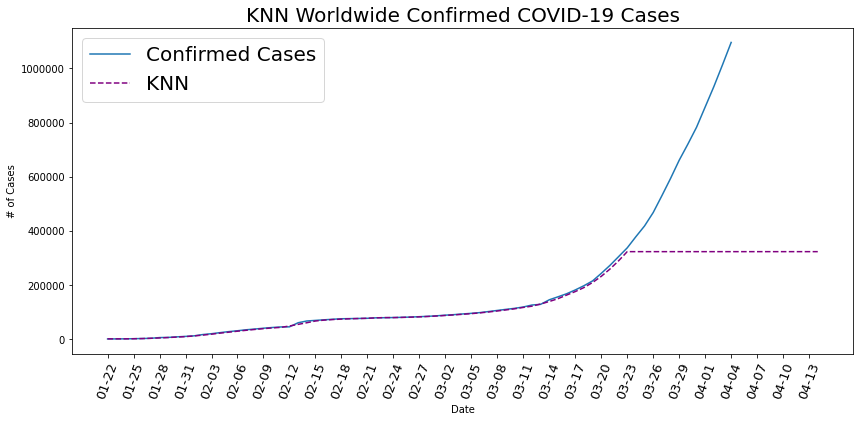

In [28]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, neighbors_world_conf_pred, linestyle='dashed', color='purple')
plt.title('KNN Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'KNN'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

## Bayesian Ridge

In [29]:
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_world_confirmed, y_train_world_confirmed)

bayesian_world_conf = bayesian_search.best_estimator_
test_bayesian_world_conf_pred = bayesian_world_conf.predict(poly_X_test_world_confirmed)
bayesian_world_conf_pred = bayesian_world_conf.predict(poly_future_world_forecast)

mAE_bayesian_world_conf = mean_absolute_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mSE_bayesian_world_conf = mean_squared_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mSLE_bayesian_world_conf = mean_squared_log_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
rMSE_bayesian_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_bayesian_world_conf_pred))
mAbE_bayesian_world_conf = median_absolute_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mAPE_bayesian_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
r2_bayesian_world_conf = r2_score(y_test_world_confirmed, test_bayesian_world_conf_pred)
mPD_bayesian_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_bayesian_world_conf_pred)
mGD_bayesian_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_bayesian_world_conf_pred)
mTD_bayesian_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_bayesian_world_conf_pred)
mE_bayesian_world_conf = max_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mEVS_bayesian_world_conf = explained_variance_score(y_test_world_confirmed, test_bayesian_world_conf_pred)

print('Bayesian Ridge on Worldwide Confirmed Cases: ')
table = [[mAE_bayesian_world_conf,mSE_bayesian_world_conf,mSLE_bayesian_world_conf,
          rMSE_bayesian_world_conf,mAbE_bayesian_world_conf,mAPE_bayesian_world_conf,
          r2_bayesian_world_conf,mPD_bayesian_world_conf,mGD_bayesian_world_conf,
          mTD_bayesian_world_conf,mE_bayesian_world_conf,mEVS_bayesian_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.7s


Bayesian Ridge on Worldwide Confirmed Cases: 


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.9s finished


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
26530.5,1.58308e+09,0.00147387,39787.9,13697,2.93058,0.965445,1492.59,0.00144451,1.58308e+09,97370.9,0.973211


In [30]:
bayesian_world_conf_pred = bayesian_world_conf_pred.reshape(1,-1)[0]
print('Bayesian Ridge Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(bayesian_world_conf_pred[-10:])))

Bayesian Ridge Worldwide Confirmed Cases Future Predictions: 


{('2020-04-04', 1315535.0),
 ('2020-04-05', 1448116.0),
 ('2020-04-06', 1591647.0),
 ('2020-04-07', 1746769.0),
 ('2020-04-08', 1914145.0),
 ('2020-04-09', 2094461.0),
 ('2020-04-10', 2288431.0),
 ('2020-04-11', 2496787.0),
 ('2020-04-12', 2720293.0),
 ('2020-04-13', 2959732.0)}

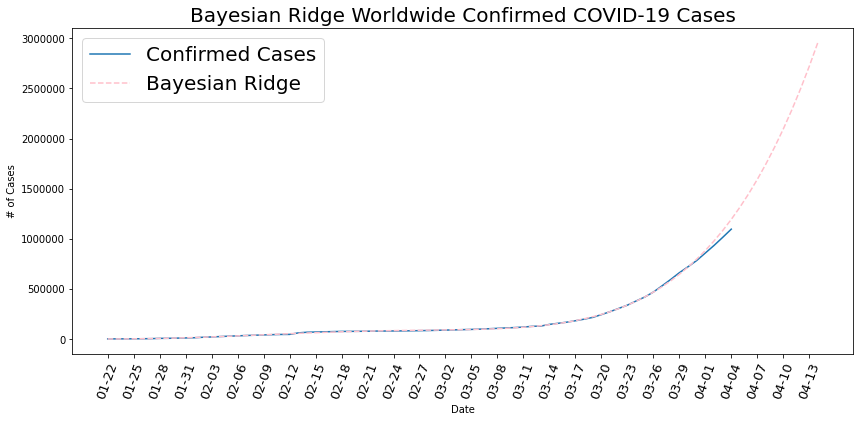

In [31]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, bayesian_world_conf_pred, linestyle='dashed', color='pink')
plt.title('Bayesian Ridge Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Bayesian Ridge'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

## Decision Tree Regressor

In [32]:
decisionTree_world_conf = DecisionTreeRegressor(random_state=0)
decisionTree_world_conf.fit(X_train_world_confirmed, y_train_world_confirmed)

#bayesian_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
#test_bayesian_world_conf_pred = bayesian_reg_model.predict(X_test_world_confirmed)
#bayesian_world_conf_pred = bayesian_reg_model.predict(future_range)

test_decisionTree_world_conf = decisionTree_world_conf.predict(X_test_world_confirmed)
decisionTree_world_conf_pred = decisionTree_world_conf.predict(future_range)

mAE_decTree_world_conf = mean_absolute_error(y_test_world_confirmed, test_decisionTree_world_conf)
mSE_decTree_world_conf = mean_squared_error(y_test_world_confirmed, test_decisionTree_world_conf)
mSLE_decTree_world_conf = mean_squared_log_error(y_test_world_confirmed, test_decisionTree_world_conf)
rMSE_decTree_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_decisionTree_world_conf))
mAbE_decTree_world_conf = median_absolute_error(y_test_world_confirmed, test_decisionTree_world_conf)
mAPE_decTree_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_decisionTree_world_conf)
r2_decTree_world_conf = r2_score(y_test_world_confirmed, test_decisionTree_world_conf)
mPD_decTree_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_decisionTree_world_conf)
mGD_decTree_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_decisionTree_world_conf)
mTD_decTree_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_decisionTree_world_conf)
mE_decTree_world_conf = max_error(y_test_world_confirmed, test_decisionTree_world_conf)
mEVS_decTree_world_conf = explained_variance_score(y_test_world_confirmed, test_decisionTree_world_conf)

print('Decision Tree on Worldwide Confirmed Cases: ')
table = [[mAE_decTree_world_conf,mSE_decTree_world_conf,mSLE_decTree_world_conf,
          rMSE_decTree_world_conf,mAbE_decTree_world_conf,mAPE_decTree_world_conf,
          r2_decTree_world_conf,mPD_decTree_world_conf,mGD_decTree_world_conf,
          mTD_decTree_world_conf,mE_decTree_world_conf,mEVS_decTree_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

Decision Tree on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
355422,1.72137e+11,0.473631,414894,341830,43.5209,-2.75741,324361,0.64351,1.72137e+11,717630,0


In [33]:
decisionTree_world_conf_pred

array([   555.,    653.,    941.,   1438.,   2118.,   2927.,   5578.,
         6165.,   8235.,   9925.,  12038.,  16787.,  19881.,  23892.,
        27636.,  30818.,  34392.,  37121.,  40151.,  42763.,  44803.,
        45222.,  60370.,  66887.,  69032.,  71226.,  73260.,  75138.,
        75641.,  76199.,  76843.,  78599.,  78985.,  79570.,  80415.,
        81397.,  82756.,  84124.,  86013.,  88371.,  90309.,  92844.,
        95124.,  97886., 101800., 105836., 109835., 113582., 118582.,
       125865., 128343., 145193., 156099., 167447., 181546., 197168.,
       214915., 242713., 272167., 304528., 337020., 378287., 378287.,
       378287., 378287., 378287., 378287., 378287., 378287., 378287.,
       378287., 378287., 378287., 378287., 378287., 378287., 378287.,
       378287., 378287., 378287., 378287., 378287., 378287.])

In [34]:
decisionTree_world_conf_pred = decisionTree_world_conf_pred.reshape(1,-1)[0]
print('Decision Tree Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(decisionTree_world_conf_pred[-10:])))

Decision Tree Worldwide Confirmed Cases Future Predictions: 


{('2020-04-04', 378287.0),
 ('2020-04-05', 378287.0),
 ('2020-04-06', 378287.0),
 ('2020-04-07', 378287.0),
 ('2020-04-08', 378287.0),
 ('2020-04-09', 378287.0),
 ('2020-04-10', 378287.0),
 ('2020-04-11', 378287.0),
 ('2020-04-12', 378287.0),
 ('2020-04-13', 378287.0)}

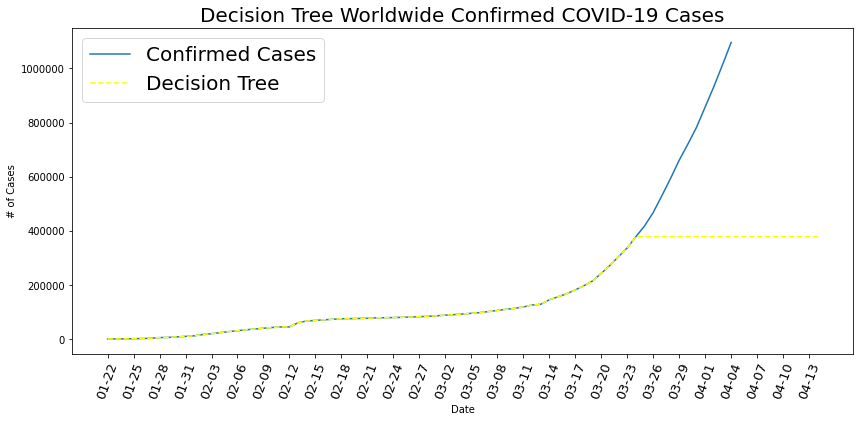

In [35]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, decisionTree_world_conf_pred, linestyle='dashed', color='yellow')
plt.title('Decision Tree Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Decision Tree'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

## Random Forest Regressor

In [36]:
#randomForest_world_conf = RandomForestRegressor(n_estimators=10, random_state=0)
#randomForest_world_conf.fit(X_train_world_confirmed, y_train_world_confirmed)
#randomForest_world_conf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
#           max_features='sqrt', max_leaf_nodes=None,
#           min_impurity_decrease=0.0, min_impurity_split=None,
#           min_samples_leaf=2, min_samples_split=5,
#           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
#           oob_score=False, random_state=None, verbose=0, warm_start=False)
#randomForest_world_conf.fit(X_train_world_confirmed , y_train_world_confirmed)

#forest = RandomForestRegressor(n_jobs=-1)
#forest.fit(X_train_world_confirmed, y_train_world_confirmed)
rf_f = RandomForestRegressor(n_estimators=100, n_jobs= -1, min_samples_leaf=3, random_state=17)

rf_f.fit(X_train_world_confirmed,y_train_world_confirmed)
#param_grid = [
#{'n_estimators': [10, 25], 'max_features': [5, 10], 
# 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
#]

#grid_search_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
#grid_search_forest.fit(X_train_world_confirmed, y_train_world_confirmed)

#randomFor_world_conf = grid_search_forest.best_estimator_
#test_randomForest_world_conf = randomFor_world_conf.predict(X_test_world_confirmed)
#randomFor_world_conf_pred = randomFor_world_conf.predict(future_range)

test_randomForest_world_conf = rf_f.predict(X_test_world_confirmed)
randomForest_world_conf_pred = rf_f.predict(future_range)

mAE_ranFor_world_conf = mean_absolute_error(y_test_world_confirmed, test_randomForest_world_conf)
mSE_ranFor_world_conf = mean_squared_error(y_test_world_confirmed, test_randomForest_world_conf)
mSLE_ranFor_world_conf = mean_squared_log_error(y_test_world_confirmed, test_randomForest_world_conf)
rMSE_ranFor_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_randomForest_world_conf))
mAbE_ranFor_world_conf = median_absolute_error(y_test_world_confirmed, test_randomForest_world_conf)
mAPE_ranFor_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_randomForest_world_conf)
r2_ranFor_world_conf = r2_score(y_test_world_confirmed, test_randomForest_world_conf)
mPD_ranFor_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_randomForest_world_conf)
mGD_ranFor_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_randomForest_world_conf)
mTD_ranFor_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_randomForest_world_conf)
mE_ranFor_world_conf = max_error(y_test_world_confirmed, test_randomForest_world_conf)
mEVS_ranFor_world_conf = explained_variance_score(y_test_world_confirmed, test_randomForest_world_conf)

print('Random Forest on Worldwide Confirmed Cases: ')
table = [[mAE_ranFor_world_conf,mSE_ranFor_world_conf,mSLE_ranFor_world_conf,
          rMSE_ranFor_world_conf,mAbE_ranFor_world_conf,mAPE_ranFor_world_conf,
          r2_ranFor_world_conf,mPD_ranFor_world_conf,mGD_ranFor_world_conf,
          mTD_ranFor_world_conf,mE_ranFor_world_conf,mEVS_ranFor_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

Random Forest on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
441129,2.40407e+11,0.85708,490314,427537,56.3172,-4.24761,529949,1.26601,2.40407e+11,803337,-4.44089e-16


In [37]:
randomForest_world_conf_pred

array([  1960.42236905,   1960.42236905,   1960.42236905,   2185.59261905,
         2650.75633333,   3605.62090476,   4794.86745238,   6544.01211219,
         8427.24152886,  10703.09111219,  11755.05743362,  13755.63668362,
        17492.45929473,  24901.83548918,  29734.67113889,  32078.65450397,
        34311.64874206,  37038.06320202,  39131.74027345,  39952.18182107,
        40245.81777345,  43916.22007107,  60990.85432215,  67619.68550902,
        68478.23267569,  69654.06470346,  71259.11875108,  74216.28120635,
        75189.61965873,  75759.95954762,  76233.874     ,  78277.81256349,
        79018.36116342,  79740.07423088,  80268.99825469,  81498.41191342,
        82625.87806421,  84073.94308802,  87090.83493939,  89389.23476227,
        90833.39548846,  92437.70339322,  94432.16701227,  98179.31041234,
       103100.4710873 , 108523.53027381, 112054.74640476, 116044.6155    ,
       119217.68772619, 122816.96285714, 127596.87961219, 144761.20573124,
       158566.90586652, 1

In [38]:
randomForest_world_conf_pred = randomForest_world_conf_pred.reshape(1,-1)[0]
print('Random Forest Worldwide Confirmed Cases Future Predictions: ')
set(zip(future_range_dates[-10:], np.round(randomForest_world_conf_pred[-10:])))

Random Forest Worldwide Confirmed Cases Future Predictions: 


{('2020-04-04', 292580.0),
 ('2020-04-05', 292580.0),
 ('2020-04-06', 292580.0),
 ('2020-04-07', 292580.0),
 ('2020-04-08', 292580.0),
 ('2020-04-09', 292580.0),
 ('2020-04-10', 292580.0),
 ('2020-04-11', 292580.0),
 ('2020-04-12', 292580.0),
 ('2020-04-13', 292580.0)}

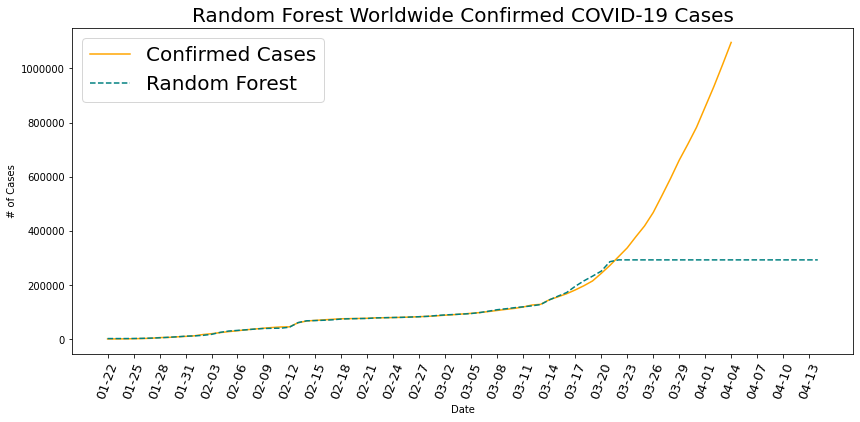

In [39]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed, color='orange')
plt.plot(future_range_dates_short, randomForest_world_conf_pred, linestyle='dashed', color='teal')
plt.title('Random Forest Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Random Forest'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

In [40]:
covidFilled.groupby(["Date", "Country", "Province_State"])[['Date', 'Province_State', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Date,Country,Province_State,Confirmed,Deaths,Recovered
0,2020-01-22,Hong Kong,Hong Kong,0.0,0.0,0.0
1,2020-01-22,Macau,Macau,1.0,0.0,0.0
2,2020-01-22,Mainland China,Anhui,1.0,0.0,0.0
3,2020-01-22,Mainland China,Beijing,14.0,0.0,0.0
4,2020-01-22,Mainland China,Chongqing,6.0,0.0,0.0
...,...,...,...,...,...,...
6123,2020-04-03,United Kingdom,Channel Islands,232.0,4.0,13.0
6124,2020-04-03,United Kingdom,Gibraltar,95.0,0.0,46.0
6125,2020-04-03,United Kingdom,Isle of Man,114.0,1.0,0.0
6126,2020-04-03,United Kingdom,Montserrat,6.0,0.0,0.0


In [41]:
covidFilled.groupby("Country")[['Confirmed', 'Deaths', 'Recovered']].last().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Azerbaijan,1.0,0.0,0.0
1,Afghanistan,281.0,6.0,10.0
2,Albania,304.0,17.0,89.0
3,Algeria,1171.0,105.0,62.0
4,Andorra,439.0,16.0,16.0
...,...,...,...,...
226,Vietnam,237.0,0.0,85.0
227,West Bank and Gaza,194.0,1.0,21.0
228,Zambia,39.0,1.0,2.0
229,Zimbabwe,9.0,1.0,0.0


In [42]:
covidFilled.groupby('Date').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,555.0,17.0,28.0
1,2020-01-23,653.0,18.0,30.0
2,2020-01-24,941.0,26.0,36.0
3,2020-01-25,1438.0,42.0,39.0
4,2020-01-26,2118.0,56.0,52.0
...,...,...,...,...
68,2020-03-30,782365.0,37582.0,164566.0
69,2020-03-31,857487.0,42107.0,178034.0
70,2020-04-01,932605.0,46809.0,193177.0
71,2020-04-02,1013157.0,52983.0,210263.0


## Prophet

In [43]:
proph_world_confirmed = covidFilled.groupby('Date').sum()['Confirmed'].reset_index()
proph_world_deaths = covidFilled.groupby('Date').sum()['Deaths'].reset_index()
proph_world_recovered = covidFilled.groupby('Date').sum()['Recovered'].reset_index()
proph_world_confirmed.columns = ['ds','y']
proph_world_confirmed['ds'] = pd.to_datetime(proph_world_confirmed['ds'])
#proph_world_confirmed.head()

proph_m_w_conf = Prophet(interval_width=0.95)
proph_m_w_conf.fit(proph_world_confirmed)
proph_future_world = proph_m_w_conf.make_future_dataframe(periods=10)
proph_future_world_confirmed = proph_future_world.copy()
#proph_future_world.tail()

proph_forecast_w_conf = proph_m_w_conf.predict(proph_future_world)
proph_w_conf = proph_forecast_w_conf[['yhat']]
proph_forecast_w_conf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
78,2020-04-09,1.344925e+06,1.291687e+06,1.391995e+06
79,2020-04-10,1.401412e+06,1.345885e+06,1.453332e+06
80,2020-04-11,1.447385e+06,1.387465e+06,1.509138e+06
81,2020-04-12,1.500510e+06,1.434380e+06,1.567936e+06
82,2020-04-13,1.554623e+06,1.475987e+06,1.635347e+06


In [44]:
metric_df = proph_forecast_w_conf.set_index('ds')[['yhat']].join(proph_world_confirmed.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

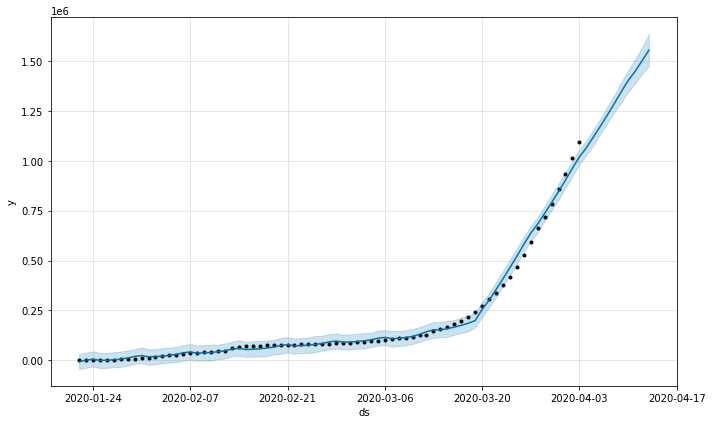

In [45]:
wor_confirmed_forecast_plot = proph_m_w_conf.plot(proph_forecast_w_conf)

In [46]:
mAE_proph_world_conf = mean_absolute_error(metric_df[['y']], metric_df[['yhat']])
mSE_proph_world_conf = mean_squared_error(metric_df[['y']], metric_df[['yhat']])
#mSLE_proph_world_conf = mean_squared_log_error(metric_df[['y']], metric_df[['yhat']])
rMSE_proph_world_conf = sqrt(mean_squared_error(metric_df[['y']], metric_df[['yhat']]))
mAbE_proph_world_conf = median_absolute_error(metric_df[['y']], metric_df[['yhat']])
mAPE_proph_world_conf = mean_absolute_percentage_error(metric_df[['y']], metric_df[['yhat']])
r2_proph_world_conf = r2_score(metric_df[['y']], metric_df[['yhat']])
#mPD_proph_world_conf = mean_poisson_deviance(metric_df[['y']], metric_df[['yhat']])
#mGD_proph_world_conf = mean_gamma_deviance(metric_df[['y']], metric_df[['yhat']])
mTD_proph_world_conf = mean_tweedie_deviance(metric_df[['y']], metric_df[['yhat']])
mE_proph_world_conf = max_error(metric_df[['y']], metric_df[['yhat']])
mEVS_proph_world_conf = explained_variance_score(metric_df[['y']], metric_df[['yhat']])

print('Prophet on Worldwide Confirmed Cases: ')

table = [[mAE_proph_world_conf,mSE_proph_world_conf,rMSE_proph_world_conf,
          mAbE_proph_world_conf,mAPE_proph_world_conf,r2_proph_world_conf,
          mTD_proph_world_conf,mE_proph_world_conf,mEVS_proph_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
           'Mean Tweedie Deviance', 'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

Prophet on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Tweedie Deviance,Max Error,Explained Variance Score
12199.5,3.78314e+08,19450.3,6652.84,41.3554,0.994243,3.78314e+08,76710.2,0.994243


In [47]:
## World Confirmed Prophet Evaluation Metrics
df_cv = cross_validation(proph_m_w_conf, initial='60 days', period='3 days', horizon = '5 days')
#df_cv.head()
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,1.616587e+10,127145.070389,126181.736797,0.222431,0.248721,0.0
1,2 days,2.849686e+10,168810.132953,167665.056431,0.265736,0.293865,0.0
2,3 days,4.409747e+10,209993.971697,209346.503395,0.302052,0.322778,0.0
3,4 days,6.423682e+10,253449.846343,253074.955821,0.332972,0.348379,0.0
4,5 days,9.194353e+10,303221.911303,302783.844019,0.363200,0.379134,0.0


In [48]:
proph_world_deaths.columns = ['ds','y']
proph_world_deaths['ds'] = pd.to_datetime(proph_world_deaths['ds'])
proph_m_w_deaths = Prophet(interval_width=0.95)
proph_m_w_deaths.fit(proph_world_deaths)
proph_future_w_deaths = proph_m_w_deaths.make_future_dataframe(periods=10)
proph_future_deaths_w = proph_future_w_deaths.copy()

forecast_deaths_proph_w = proph_m_w_deaths.predict(proph_future_w_deaths)
forecast_deaths_proph_w[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
78,2020-04-09,68573.773164,65220.464639,71748.740270
79,2020-04-10,71649.160864,67911.759261,75275.496881
80,2020-04-11,73740.115172,69608.491523,77609.604359
81,2020-04-12,76579.690135,72544.751672,80882.034859
82,2020-04-13,79497.009580,74690.201078,83837.621132


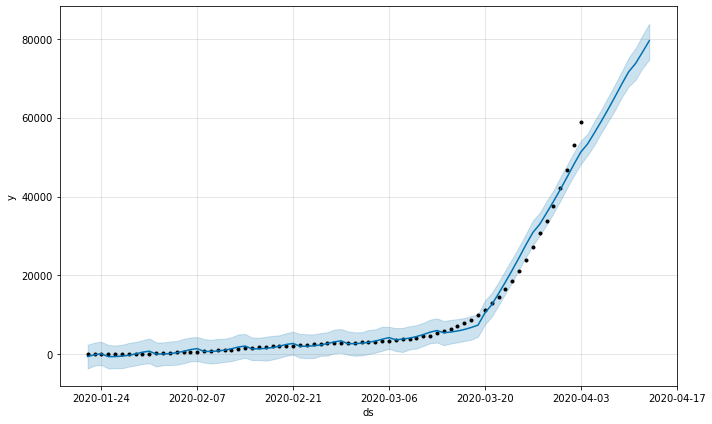

In [49]:
proph_w_deaths_forecast_plot = proph_m_w_deaths.plot(forecast_deaths_proph_w)

In [50]:
df_cv = cross_validation(proph_m_w_deaths, initial='60 days', period='3 days', horizon = '5 days')
#df_cv.head()
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,3.419026e+07,5847.243498,5743.434919,0.211994,0.212722,0.0
1,2 days,6.711807e+07,8192.561865,8049.796777,0.263361,0.262619,0.0
2,3 days,1.115089e+08,10559.778140,10392.416154,0.305350,0.298205,0.0
3,4 days,1.890479e+08,13749.467657,13470.956547,0.350202,0.333236,0.0
4,5 days,2.906540e+08,17048.577546,16732.007899,0.389257,0.374218,0.0


## Florida COVID-19 Case Predictions

In [51]:
proph_flconfirmed = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Confirmed']].sum().reset_index()
proph_fldeaths = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Deaths']].sum().reset_index()
proph_flrecovered = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Recovered']].sum().reset_index()
proph_flconfirmed.columns = ['ds','y']
#flconfirmed['ds'] = flconfirmed['ds'].dt.date
proph_flconfirmed['ds'] = pd.to_datetime(proph_flconfirmed['ds'])
proph_flconfirmed.tail()
#proph_flconfirmed.head()


,ds,y
20,2020-03-30,5473.0
21,2020-03-31,6741.0
22,2020-04-01,6956.0
23,2020-04-02,9008.0
24,2020-04-03,10268.0


In [52]:
fl_m = Prophet(interval_width=0.95)
fl_m.fit(proph_flconfirmed)
fl_future = fl_m.make_future_dataframe(periods=10)
fl_future_confirmed = fl_future.copy()
#fl_future.tail()
fl_forecast = fl_m.predict(fl_future)
fl_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
30,2020-04-09,9293.383375,6613.767010,11994.922594
31,2020-04-10,9784.772760,6950.921545,12622.324200
32,2020-04-11,9104.984608,6402.977940,11835.151658
33,2020-04-12,9394.333372,6738.248658,12078.840849
34,2020-04-13,9891.339494,7229.927701,12670.598151


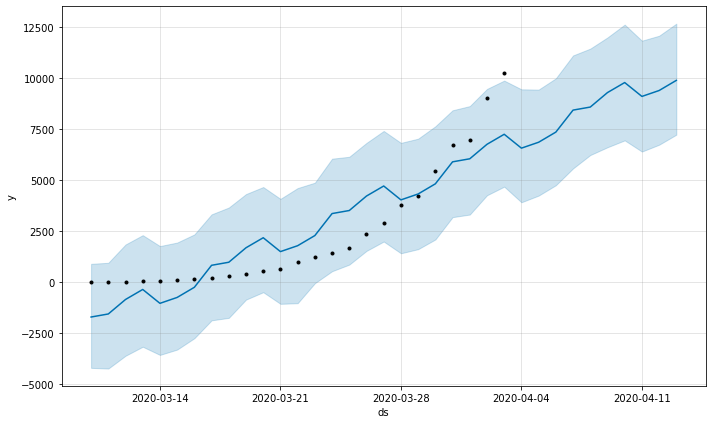

In [53]:
fl_confirmed_forecast_plot = fl_m.plot(fl_forecast)

In [54]:
proph_fldeaths.columns = ['ds','y']
proph_fldeaths['ds'] = pd.to_datetime(proph_fldeaths['ds'])
fl_m = Prophet(interval_width=0.95)
fl_m.fit(proph_fldeaths)
fl_future = fl_m.make_future_dataframe(periods=7)
fl_future_deaths = fl_future.copy() # for non-baseline predictions later on
#fl_future.tail()
fl_forecast = fl_m.predict(fl_future)
fl_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2020-04-06,101.318908,54.031381,151.639997
28,2020-04-07,118.558819,69.158957,165.725957
29,2020-04-08,120.560131,71.066032,168.953205
30,2020-04-09,141.808932,96.405792,190.587462
31,2020-04-10,145.059345,99.356216,191.509556


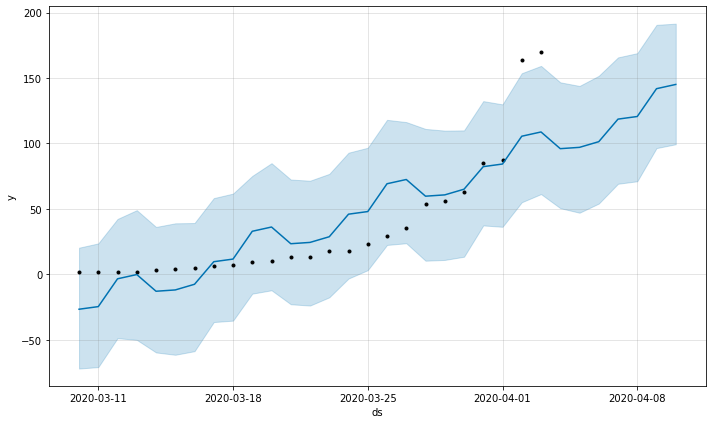

In [55]:
fl_deaths_forecast_plot = fl_m.plot(fl_forecast)

## Worldwide Confirmed Cases Model Predictions

In [56]:
table = [[future_range_dates[-11:-10][0], np.round(linear_world_conf_pred[-11:-10]),
          np.round(poly_world_conf_pred[-11:-10]),np.round(svm_world_conf_pred[-11:-10]),
         np.round(xgb_world_conf_pred[-11:-10]),np.round(bayesian_world_conf_pred[-11:-10]),
         np.round(decisionTree_world_conf_pred[-11:-10]),np.round(randomForest_world_conf_pred[-11:-10]),
         proph_forecast_w_conf[['yhat']][-11:-10].values[0][0]],
         [future_range_dates[-10:-9][0],np.round(linear_world_conf_pred[-10:-9]),
          np.round(poly_world_conf_pred[-10:-9]),np.round(svm_world_conf_pred[-10:-9]),
         np.round(xgb_world_conf_pred[-10:-9]),np.round(bayesian_world_conf_pred[-10:-9]),
         np.round(decisionTree_world_conf_pred[-10:-9]),np.round(randomForest_world_conf_pred[-10:-9]),
         proph_forecast_w_conf[['yhat']][-10:-9].values[0][0]],
         [future_range_dates[-9:-8][0],np.round(linear_world_conf_pred[-9:-8]),
          np.round(poly_world_conf_pred[-9:-8]),np.round(svm_world_conf_pred[-9:-8]),
         np.round(xgb_world_conf_pred[-9:-8]),np.round(bayesian_world_conf_pred[-9:-8]),
         np.round(decisionTree_world_conf_pred[-9:-8]),np.round(randomForest_world_conf_pred[-9:-8]),
         proph_forecast_w_conf[['yhat']][-9:-8].values[0][0]],
         [future_range_dates[-8:-7][0],np.round(linear_world_conf_pred[-8:-7]),
          np.round(poly_world_conf_pred[-8:-7]),np.round(svm_world_conf_pred[-8:-7]),
         np.round(xgb_world_conf_pred[-8:-7]),np.round(bayesian_world_conf_pred[-8:-7]),
         np.round(decisionTree_world_conf_pred[-8:-7]),np.round(randomForest_world_conf_pred[-8:-7]),
         proph_forecast_w_conf[['yhat']][-8:-7].values[0][0]],
         [future_range_dates[-7:-6][0],np.round(linear_world_conf_pred[-7:-6]),
          np.round(poly_world_conf_pred[-7:-6]),np.round(svm_world_conf_pred[-7:-6]),
         np.round(xgb_world_conf_pred[-7:-6]),np.round(bayesian_world_conf_pred[-7:-6]),
         np.round(decisionTree_world_conf_pred[-7:-6]),np.round(randomForest_world_conf_pred[-7:-6]),
         proph_forecast_w_conf[['yhat']][-7:-6].values[0][0]],
         [future_range_dates[-6:-5][0],np.round(linear_world_conf_pred[-6:-5]),
          np.round(poly_world_conf_pred[-6:-5]),np.round(svm_world_conf_pred[-6:-5]),
         np.round(xgb_world_conf_pred[-6:-5]),np.round(bayesian_world_conf_pred[-6:-5]),
         np.round(decisionTree_world_conf_pred[-6:-5]),np.round(randomForest_world_conf_pred[-6:-5]),
         proph_forecast_w_conf[['yhat']][-6:-5].values[0][0]],
         [future_range_dates[-5:-4][0],np.round(linear_world_conf_pred[-5:-4]),
          np.round(poly_world_conf_pred[-5:-4]),np.round(svm_world_conf_pred[-5:-4]),
         np.round(xgb_world_conf_pred[-5:-4]),np.round(bayesian_world_conf_pred[-5:-4]),
         np.round(decisionTree_world_conf_pred[-5:-4]),np.round(randomForest_world_conf_pred[-5:-4]),
         proph_forecast_w_conf[['yhat']][-5:-4].values[0][0]],
         [future_range_dates[-4:-3][0],np.round(linear_world_conf_pred[-4:-3]),
          np.round(poly_world_conf_pred[-4:-3]),np.round(svm_world_conf_pred[-4:-3]),
         np.round(xgb_world_conf_pred[-4:-3]),np.round(bayesian_world_conf_pred[-4:-3]),
         np.round(decisionTree_world_conf_pred[-4:-3]),np.round(randomForest_world_conf_pred[-4:-3]),
         proph_forecast_w_conf[['yhat']][-4:-3].values[0][0]],
         [future_range_dates[-3:-2][0],np.round(linear_world_conf_pred[-3:-2]),
          np.round(poly_world_conf_pred[-3:-2]),np.round(svm_world_conf_pred[-3:-2]),
         np.round(xgb_world_conf_pred[-3:-2]),np.round(bayesian_world_conf_pred[-3:-2]),
         np.round(decisionTree_world_conf_pred[-3:-2]),np.round(randomForest_world_conf_pred[-3:-2]),
         proph_forecast_w_conf[['yhat']][-3:-2].values[0][0]],
         [future_range_dates[-2:-1][0],np.round(linear_world_conf_pred[-2:-1]),
          np.round(poly_world_conf_pred[-2:-1]),np.round(svm_world_conf_pred[-2:-1]),
         np.round(xgb_world_conf_pred[-2:-1]),np.round(bayesian_world_conf_pred[-2:-1]),
         np.round(decisionTree_world_conf_pred[-2:-1]),np.round(randomForest_world_conf_pred[-2:-1]),
         proph_forecast_w_conf[['yhat']][-2:-1].values[0][0]],
         [future_range_dates[-1:][0],np.round(linear_world_conf_pred[-1:]),
          np.round(poly_world_conf_pred[-1:]),np.round(svm_world_conf_pred[-1:]),
         np.round(xgb_world_conf_pred[-1:]),np.round(bayesian_world_conf_pred[-1:]),
         np.round(decisionTree_world_conf_pred[-1:]),np.round(randomForest_world_conf_pred[-1:]),
         proph_forecast_w_conf[['yhat']][-1:].values[0][0]]]
headName = ['Date', 'Linear', 'Polynomial', 'SVM', 'XGBoost', 'Bayesian', 'Decision Tree', 'Random Forest', 'Prophet']
print('Most Recent Date:',future_range_dates[-11:-10][0])
print('Confirmed Cases:', int(world_confirmed[-1:][0]))
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

Most Recent Date: 2020-04-03
Confirmed Cases: 1095917


Date,Linear,Polynomial,SVM,XGBoost,Bayesian,Decision Tree,Random Forest,Prophet
2020-04-03,232977,1.17338e+06,877107,599799,1.19329e+06,378287,292580,1.01921e+06
2020-04-04,236212,1.29194e+06,948927,634651,1.31554e+06,378287,292580,1.06518e+06
2020-04-05,239448,1.42035e+06,1.02584e+06,671270,1.44812e+06,378287,292580,1.1183e+06
2020-04-06,242684,1.5592e+06,1.10813e+06,709725,1.59165e+06,378287,292580,1.17242e+06
2020-04-07,245920,1.70909e+06,1.19609e+06,750087,1.74677e+06,378287,292580,1.22823e+06
2020-04-08,249156,1.87064e+06,1.29003e+06,792428,1.91414e+06,378287,292580,1.28535e+06
2020-04-09,252391,2.04449e+06,1.39027e+06,836821,2.09446e+06,378287,292580,1.34492e+06
2020-04-10,255627,2.23129e+06,1.49715e+06,883344,2.28843e+06,378287,292580,1.40141e+06
2020-04-11,258863,2.43175e+06,1.61101e+06,932074,2.49679e+06,378287,292580,1.44739e+06
2020-04-12,262099,2.64655e+06,1.73222e+06,983091,2.72029e+06,378287,292580,1.50051e+06


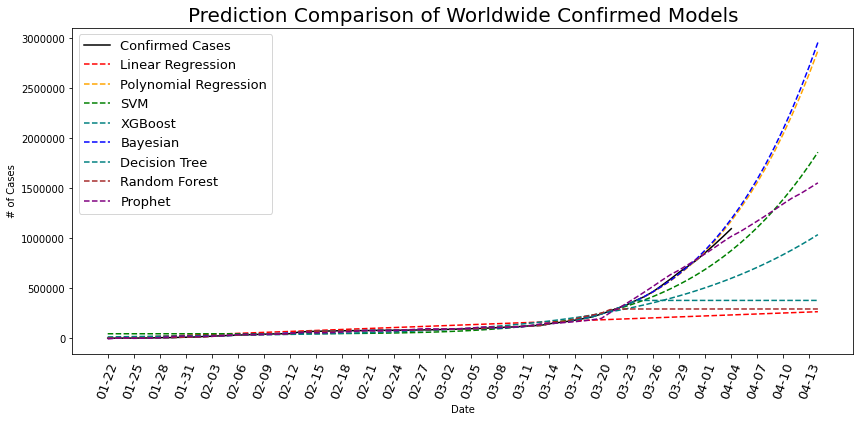

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed, color='black')
plt.plot(future_range_dates_short, linear_world_conf_pred, linestyle='dashed', color='red')
plt.plot(future_range_dates_short, poly_world_conf_pred, linestyle='dashed', color='orange')
plt.plot(future_range_dates_short, svm_world_conf_pred, linestyle='dashed', color='green')
plt.plot(future_range_dates_short, xgb_world_conf_pred, linestyle='dashed', color='teal')
plt.plot(future_range_dates_short, bayesian_world_conf_pred, linestyle='dashed', color='blue')
plt.plot(future_range_dates_short, decisionTree_world_conf_pred, linestyle='dashed', color='teal')
plt.plot(future_range_dates_short, randomForest_world_conf_pred, linestyle='dashed', color='brown')
plt.plot(future_range_dates_short, proph_w_conf, linestyle='dashed', color='purple')
plt.title('Prediction Comparison of Worldwide Confirmed Models', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Linear Regression', 'Polynomial Regression', 'SVM', 'XGBoost', 'Bayesian', 'Decision Tree', 'Random Forest', 'Prophet'], prop={'size': 13})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()

## Combined Evaluation Metrics
#### Results from models throughout this notebook can be seen below:

In [58]:
table = [["Mean Absolute Err",mAE_linear_world_conf, mAE_poly_world_conf, mAE_svm_world_conf, mAE_xgb_world_conf,mAE_bayesian_world_conf,mAE_decTree_world_conf,mAE_ranFor_world_conf,mAE_proph_world_conf],
         ["Mean Squared Err",mSE_linear_world_conf,mSE_poly_world_conf,mSE_svm_world_conf,mSE_xgb_world_conf,mSE_bayesian_world_conf,mSE_decTree_world_conf,mSE_ranFor_world_conf,mSE_proph_world_conf],
         ["Mean Squared Log Err",mSLE_linear_world_conf,mSLE_poly_world_conf,mSLE_svm_world_conf,mSLE_xgb_world_conf,mSLE_bayesian_world_conf,mSLE_decTree_world_conf,mSLE_ranFor_world_conf],
         ["Root Mean Squared Err",rMSE_linear_world_conf,rMSE_poly_world_conf,rMSE_svm_world_conf,rMSE_xgb_world_conf,rMSE_bayesian_world_conf,rMSE_decTree_world_conf,rMSE_ranFor_world_conf,rMSE_proph_world_conf],
         ["Median Absolute Err",mAbE_linear_world_conf,mAbE_poly_world_conf,mAbE_svm_world_conf,mAbE_xgb_world_conf,mAbE_bayesian_world_conf,mAbE_decTree_world_conf,mAbE_ranFor_world_conf,mAbE_proph_world_conf],
         ["Mean Absolute Percentage Err",mAPE_linear_world_conf,mAPE_poly_world_conf,mAPE_svm_world_conf,mAPE_xgb_world_conf,mAPE_bayesian_world_conf,mAPE_decTree_world_conf,mAPE_ranFor_world_conf,mAPE_proph_world_conf],
         ["R2 Score",r2_linear_world_conf,r2_poly_world_conf,r2_svm_world_conf,r2_xgb_world_conf,r2_bayesian_world_conf,r2_decTree_world_conf,r2_ranFor_world_conf,r2_proph_world_conf],
         ["Mean Poisson Deviance",mPD_linear_world_conf,mPD_poly_world_conf,mPD_svm_world_conf,mPD_xgb_world_conf,mPD_bayesian_world_conf,mPD_decTree_world_conf,mPD_ranFor_world_conf],
         ["Mean Gamma Deviance",mGD_linear_world_conf,mGD_poly_world_conf,mGD_svm_world_conf,mGD_xgb_world_conf,mGD_bayesian_world_conf,mGD_decTree_world_conf,mGD_ranFor_world_conf],
         ["Mean Tweedie Deviance",mTD_linear_world_conf,mTD_poly_world_conf,mTD_svm_world_conf,mTD_xgb_world_conf,mTD_bayesian_world_conf,mTD_decTree_world_conf,mTD_ranFor_world_conf,mTD_proph_world_conf],
         ["Max Error",mE_linear_world_conf,mE_poly_world_conf,mE_svm_world_conf,mE_xgb_world_conf,mE_bayesian_world_conf,mE_decTree_world_conf,mE_ranFor_world_conf,mE_proph_world_conf],
         ["Explained Variance Score",mEVS_linear_world_conf,mEVS_poly_world_conf,mEVS_svm_world_conf,mEVS_xgb_world_conf,mEVS_bayesian_world_conf,mEVS_decTree_world_conf,mEVS_ranFor_world_conf,mEVS_proph_world_conf]]
headName = ['Evaluation Metric', 'Linear', 'Polynomial', 'SVM', 'XGBoost', 'Bayesian', 'Decision Tree', 'Random Forest', 'Prophet']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

Evaluation Metric,Linear,Polynomial,SVM,XGBoost,Bayesian,Decision Tree,Random Forest,Prophet
Mean Absolute Err,516911,22124.6,130381,276973,26530.5,355422,441129,12199.5
Mean Squared Err,3.08743e+11,9.83979e+08,2.04481e+10,9.36655e+10,1.58308e+09,1.72137e+11,2.40407e+11,3.78314e+08
Mean Squared Log Err,1.44761,0.0010241,0.0362792,0.213546,0.00147387,0.473631,0.85708,
Root Mean Squared Err,555646,31368.4,142997,306048,39787.9,414894,490314,19450.3
Median Absolute Err,503319,13936.6,134922,270348,13697,341830,427537,6652.84
Mean Absolute Percentage Err,68.0943,2.58176,16.7834,35.5323,2.93058,43.5209,56.3172,41.3554
R2 Score,-5.73923,0.978522,0.553658,-1.04453,0.965445,-2.75741,-4.24761,0.994243
Mean Poisson Deviance,799747,972.076,27508.6,150768,1492.59,324361,529949,
Mean Gamma Deviance,2.33937,0.00101234,0.0388727,0.254492,0.00144451,0.64351,1.26601,
Mean Tweedie Deviance,3.08743e+11,9.83979e+08,2.04481e+10,9.36655e+10,1.58308e+09,1.72137e+11,2.40407e+11,3.78314e+08


#### The table above serves to compare the evaluation metrics of each model against different regions and sizes of data. As the same models are applied to different sizes of data sets, the evaluation metrics are compared and show which models have more acceptable errors for those particular data set sizes based on region selected.